In [24]:
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; float:center}</style>")

In [25]:
from __future__ import division, print_function

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score




%matplotlib inline



sns.set_context('talk', font_scale=1.5)
sns.set_style('ticks', {'font.family': [u'sans-serif']})

punctuation = ['.',',',':','!',';','-','?','"',"'",'(',')','—']   
other = ['ive','ve', "i've", "i'v", 'i’ll', 'i’ve', 'i’v']  # 'deb','hideb','don','didn','twaittry','doesn','thank','heydeb',
mystops = stopwords.words('english') + punctuation + other


import & sanity check

In [31]:
comments_with_sentences_100_classified = pd.read_csv('/Users/kateliea/Documents/Insight/project/algorithm/training_data.csv',index_col=0)
# comments_with_sentences_100_classified = comments_with_sentences_100_classified.dropna(how='any')

# comments_with_sentences_100_classified = comments_with_sentences_100_classified.dropna()

# comments_with_sentences_100_classified['category_simple'] = comments_with_sentences_100_classified.category
# comments_with_sentences_100_classified['category_simple'] = comments_with_sentences_100_classified.category_simple.replace(['addition','substitution','omission'],'helpful')

# comments_with_sentences_100_classified.category_simple.unique()

In [32]:
comments_with_sentences_100_classified.columns

Index(['sentence', 'commentID', 'child_id', 'children', 'comment_time',
       'recipenumber', 'title', 'url', 'usercomment', 'username', 'usersite',
       'usercomment_lower', 'tokens', 'tokens_stemmed', 'sentence_tokens',
       'sentence_tokens_stemmed_stops', 'sentence_tokens_stemmed', 'category',
       'category_simple'],
      dtype='object')

# pipeline - identify 'helpful' vs 'other' comments

### define data sets

In [18]:
X = comments_with_sentences_100_classified.sentence_tokens_stemmed
Y = comments_with_sentences_100_classified.category_simple


num_folds = 10
num_instances = len(X)
seed = 42

kfold = KFold(n=num_instances, n_folds=num_folds, random_state=seed)



# split = 20000
# X_train = comments_with_sentences_100_classified.sentence_tokens_stemmed[:split] #\.as_matrix()
# target_train = comments_with_sentences_100_classified.category_simple[:split] #.as_matrix()
# target_train.replace(['addition','substitution','omission'],'helpful',inplace=True)


# X_test = comments_with_sentences_100_classified.sentence_tokens_stemmed[split:]
# target_test = comments_with_sentences_100_classified.category_simple[split:]
# target_test.replace(['addition','substitution','omission'],'helpful',inplace=True)

split = 20000
X_train = comments_with_sentences_100_classified.sentence_tokens[:split] #\.as_matrix()
target_train = comments_with_sentences_100_classified.category_simple[:split] #.as_matrix()
target_train.replace(['addition','substitution','omission'],'helpful',inplace=True)


X_test = comments_with_sentences_100_classified.sentence_tokens[split:]
target_test = comments_with_sentences_100_classified.category_simple[split:]
target_test.replace(['addition','substitution','omission'],'helpful',inplace=True)

test_all = comments_with_sentences_100_classified[split:]

# encode classes labels as ints
target_test_bin = LabelEncoder().fit_transform(target_test)
# list(labelencoder.classes_)

len(X_test), len(target_test)

print('total comments that should be helpful, %i' % test_all[test_all.category_simple == 'helpful'].category.count())
print('total comments that should be other, %i' % test_all[test_all.category_simple == 'other'].category.count())

total comments that should be helpful, 5192
total comments that should be other, 69419


## Naive Bayes classifier

In [10]:
classifier_helpful_NB = Pipeline([('vectorizer', CountVectorizer(ngram_range=(2,6), max_df=1000000, min_df=3)),
                                  ('transformer', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
                                  
                                  ('classifier', MultinomialNB(alpha=1.0, class_prior=[0.1,0.9], fit_prior=True))])


# classifier_helpful_NB = Pipeline([('vectorizer', CountVectorizer(ngram_range=(2,6), stop_words=mystops, max_df=1000000, min_df=3)),
#                                   ('transformer', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
#                                   ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

classifier_helpful_NB.fit(X_train, target_train) 
predicted_NB = classifier_helpful_NB.predict(X_test) 
confmatrix_NB = confusion_matrix(target_test, predicted_NB)
probs_NB = classifier_helpful_NB.predict_proba(X_test)

predicted_NB_bin = LabelEncoder().fit_transform(predicted_NB)
falsepos_NB, truepos_NB, _ = sklearn.metrics.roc_curve(target_test_bin, probs_NB[:,1]) # 2nd column is positive class


print('accuracy, %0.4f' % np.mean(predicted_NB == target_test))
print('score, %0.4f' % classifier_helpful_NB.score(X_test,target_test))
print('confusion matrix', confmatrix_NB)
print('correctly classified helpful %i' % test_all[(test_all.category_simple == predicted_NB) & (test_all.category_simple == 'helpful' )].shape[0])
print('prob/recall/F1', precision_recall_fscore_support(target_test_bin, predicted_NB_bin))

accuracy, 0.9387
score, 0.9387
confusion matrix [[  633  4559]
 [   16 69403]]
correctly classified helpful 633
prob/recall/F1 (array([ 0.97534669,  0.93836024]), array([ 0.12191834,  0.99976952]), array([ 0.21674371,  0.96809201]), array([ 5192, 69419]))


In [395]:
results_NB = cross_val_score(classifier_helpful_NB, X, Y, cv=kfold)
print(results_NB.mean())

0.947321155628


## stochastic gradient descent classifier (logarithmic)

accuracy, 0.9329
score, 0.9329
confusion matrix [[ 2762  2430]
 [ 2578 66841]]
correctly classified helpful 2762
(array([ 0.51722846,  0.96492039]), array([ 0.53197227,  0.96286319]), array([ 0.52449677,  0.96389069]), array([ 5192, 69419]))


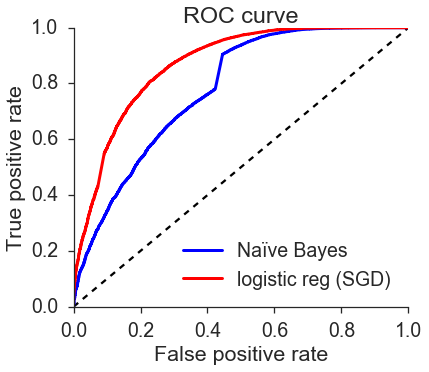

In [17]:
classifier_helpful_SGD = Pipeline([('vectorizer', CountVectorizer(ngram_range=(2,6), max_df=1000000, min_df=2)),
                                   ('transformer', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
                                   ('classifier', SGDClassifier(alpha=0.0005, average=False, class_weight={'helpful':8.5, 'other':0.7}, epsilon=0.1,
                                eta0=0, fit_intercept=True, l1_ratio=0, learning_rate='optimal', loss='log', n_iter=50, n_jobs=1,
                                penalty='l2', power_t=0.5, random_state=42, shuffle=True))])


# classifier_helpful_SGD = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,6), stop_words=mystops, max_df=100000, min_df=2)),
#                                    ('transformer', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
#                                    ('classifier', SGDClassifier(alpha=0.0005, average=False, class_weight={'helpful':8.5, 'other':0.7}, epsilon=0.1,
#                                 eta0=0, fit_intercept=True, l1_ratio=0, learning_rate='optimal', loss='log', n_iter=50, n_jobs=1,
#                                 penalty='l2', power_t=0.5, random_state=42, shuffle=True))])

classifier_helpful_SGD = classifier_helpful_SGD.fit(X_train, target_train)
predicted_SGD = classifier_helpful_SGD.predict(X_test)
confmatrix_SGD = confusion_matrix(target_test, predicted_SGD)
probs_SGD = classifier_helpful_SGD.predict_proba(X_test)

predicted_SGD_bin = LabelEncoder().fit_transform(predicted_SGD)
falsepos_SGD, truepos_SGD, _ = sklearn.metrics.roc_curve(target_test_bin, probs_SGD[:,1]) # 2nd column is positive class


print('accuracy, %0.4f' % np.mean(predicted_SGD == target_test))
print('score, %0.4f' % classifier_helpful_SGD.score(X_test,target_test))
print('confusion matrix', confmatrix_SGD)
print('correctly classified helpful %i' % test_all[(test_all.category_simple == predicted_SGD) & (test_all.category_simple == 'helpful' )].shape[0])
# print('prob/recall/F1', precision_recall_fscore_support(target_test_bin, predicted_SGD_bin))
print(precision_recall_fscore_support(target_test_bin, predicted_SGD_bin))

lw = 3
fig, ax = plt.subplots(figsize=(6,5))
ax.plot([0,1],[0,1],'k--')
ax.plot(falsepos_NB, truepos_NB, 'b', label='Naïve Bayes', linewidth=lw)
ax.plot(falsepos_SGD, truepos_SGD, 'r', label='logistic reg (SGD)', linewidth=lw)

ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC curve')
ax.legend(loc='best')
sns.despine()

# plt.savefig('ROC_curve.jpg')

# pipeline - identify 'substitute' vs 'add/omit' versus comments 

In [14]:
a = comments_with_sentences_100_classified[comments_with_sentences_100_classified.title == 'best cocoa brownies']
a.shape

(3439, 20)

In [15]:
predicted_SGD = classifier_helpful_SGD.predict(a.sentence_tokens_stemmed)


In [17]:
a.iloc[predicted_SGD == 'helpful'].sentence.to_csv('predicted_helpful_brownies')

In [18]:
b = pd.read_csv('predicted_helpful_brownies')

In [19]:
b

,882,i need to make these immediately!
0,886,cocoa is just easier.
1,894,is this a particular reason to use wood and no...
2,898,jacob picture — i forgot!
3,899,i added something that will more than make up ...
4,903,i did use an 8″ square.
5,923,"i like boxed brownies, too, except for the one..."
6,926,i never use one.
7,942,"i have everything at home, so i think i’ll mak..."
8,944,these are similar to the king arthur flour fud...
9,945,i am totally a convert and thumb my nose at u...
